In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
from pandarus import *
from rasterio import plot as rp
import geopandas as gpd
import json
import os
import pandas as pd
import rasterio

In [3]:
ls ../tests/data/

DEM.tif
big-grid.geojson
duplicates.geojson
gc.geojson
grid-3410.geojson
grid-ints.geojson
grid.geojson
i_result.json
inpt.tif
intersection_result.geojson
intersection_result.json.bz2
invalid.txt
json_test.json
json_test.json.bz2
lines-25000.geojson
lines.geojson
outside.geojson
pandarus-worker-18-March-2017-10-24AM.log
pandarus-worker-22-March-2017-10-06AM.log
pandarus-worker-22-March-2017-10-07AM.log
pandarus-worker-22-March-2017-10-08AM.log
pandarus-worker-22-March-2017-10-12AM.log
pandarus-worker-22-March-2017-10-13AM.log
point.geojson
points-32631.geojson
points.geojson
range.tif
raster_cfs_32bit.tif
remaining.geojson
square-3857.geojson
square.geojson
test_countries.gpkg
test_provinces.gpkg
test_raster_cfs.tif
test_raster_loading.tif
testfile.hash


In [4]:
provinces = gpd.read_file(os.path.join("..", "tests", "data", "test_provinces.gpkg"))
big_grid = gpd.read_file(os.path.join("..", "tests", "data", "big-grid.geojson"))
grid_fp = os.path.join("..", "tests", "data", "grid.geojson")
grid = gpd.read_file(grid_fp)
range_fp = os.path.join('..', 'tests', 'data', 'range.tif')
grid_fp = os.path.join('..', 'tests', 'data', 'grid.geojson')
outside_fp = os.path.join('..', 'tests', 'data', 'outside.geojson')

# Match two vector datasets

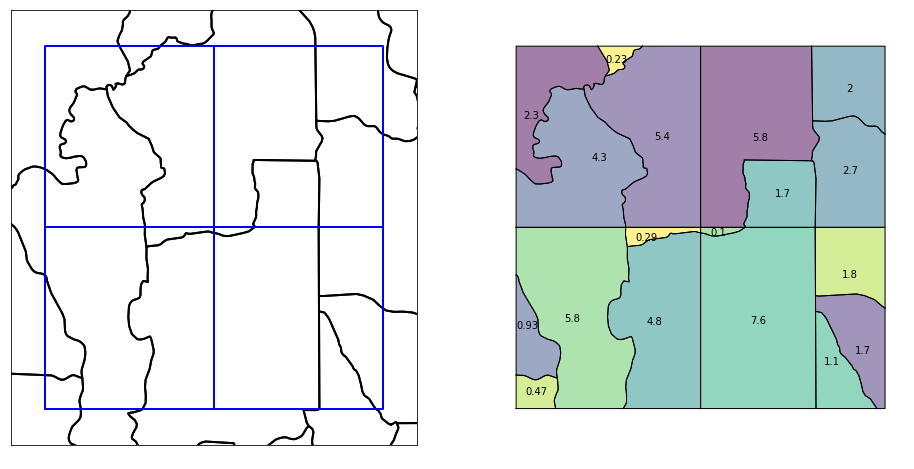

In [32]:
figure, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 8))
provinces.plot(color='white', figsize=(6, 6), ax=ax1, linewidth=2)
big_grid.plot(ax=ax1, alpha=0.5, facecolor='None', edgecolor='blue', linewidth=2)
ax1.set_xlim(-0.2, 2.2)
ax1.set_ylim(6.8, 9.2)
ax1.set_xticks([])
ax1.set_yticks([])

spatial_result, _ = intersect(
    "../tests/data/big-grid.geojson", 
    'name',
    "../tests/data/test_provinces.gpkg", 
    'name'
)

intersection = gpd.read_file(spatial_result)

intersection.plot(ax=ax2, alpha=0.5)
intersection.apply(
    lambda x: ax2.annotate(
        s="{:2.2g}".format(x['measure'] / 1e9), 
        xy=x.geometry.representative_point().coords[0], 
        ha='center',
        va='center'), 
    axis=1
)
ax2.axis('off')
plt.savefig("images/two-vectors.png", bbox_inches='tight', transparent=True)

# Calculate remaining

{'data': [['by-myself', 6191048105.585926]], 'metadata': {'when': '2017-03-22T10:16:16.750723', 'source': {'field': 'name', 'path': '/Users/cmutel/Code/pandarus/tests/data/outside.geojson', 'sha256': '93eea118fb06ff7e0472596af6e32c55dab24afbc7c0827040d9822104d3945d', 'filename': 'outside.geojson'}, 'intersections': {'field': 'id', 'path': '/Users/cmutel/Library/Application Support/pandarus/intersections/93eea118fb06ff7e0472596af6e32c55dab24afbc7c0827040d9822104d3945d.5f261833d583cf59067d2019bde4d024093e8755aa37ae3d966cc8f4e32da7a0.geojson', 'sha256': '0c11f07f00f2e583ecc3f2ae760d2d7a50b100d822b686851c7e7de0c0b811c5', 'filename': '93eea118fb06ff7e0472596af6e32c55dab24afbc7c0827040d9822104d3945d.5f261833d583cf59067d2019bde4d024093e8755aa37ae3d966cc8f4e32da7a0.geojson'}}}
(1.0, 2.0)


/Users/cmutel/miniconda3/envs/p2/lib/python3.5/site-packages/geopandas/plotting.py:229: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


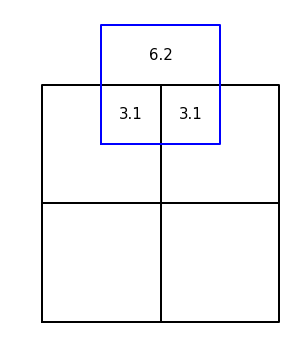

In [6]:
intersections_fp, _ = intersect(outside_fp, "name", grid_fp, "name")
remaining_fp = calculate_remaining(outside_fp, 'name', intersections_fp, compress=False)
remaining_data = json.load(open(remaining_fp))

print(remaining_data)

ax = grid.plot(color='white', figsize=(6, 6), linewidth=2)
# gpd.read_file(outside_fp).plot(axes=ax, alpha=0.5, facecolor='None', edgecolor='blue', linewidth=2)

def raise_up(coords):
    print(coords)
    return (coords[0], coords[1] + 0.25)

outside = gpd.read_file(outside_fp)
merged = outside.merge(pd.DataFrame(remaining_data['data'], columns=['name', 'outside']))
merged.plot(axes=ax, alpha=0.5, facecolor='None', edgecolor='blue', linewidth=2)
merged.apply(
    lambda x: ax.annotate(
        s="{:2.2g}".format(x['outside'] / 1e9), 
        xy=raise_up(x.geometry.representative_point().coords[0]), 
        ha='center',
        va='center', 
        size=15),
    axis=1
)
ax.text(
    0.75, 
    1.75, 
    '3.1',
    size=15,
    va='center',
    ha='center'
)
ax.text(
    1.25, 
    1.75, 
    '3.1',
    size=15,
    va='center',
    ha='center'
)
ax.axis('off')
plt.savefig("images/outside.png", bbox_inches='tight', transparent=True)

# Raster statistics

In [15]:
json_data = json.load(open(Pandarus(
    grid_fp, 
    from_metadata={'field': 'name'}, 
).rasterstats(range_fp, compressed=False)))

In [23]:
merged = grid.merge(pd.DataFrame([(x, y['mean']) for x, y in json_data['data']], columns=['name', 'value']))

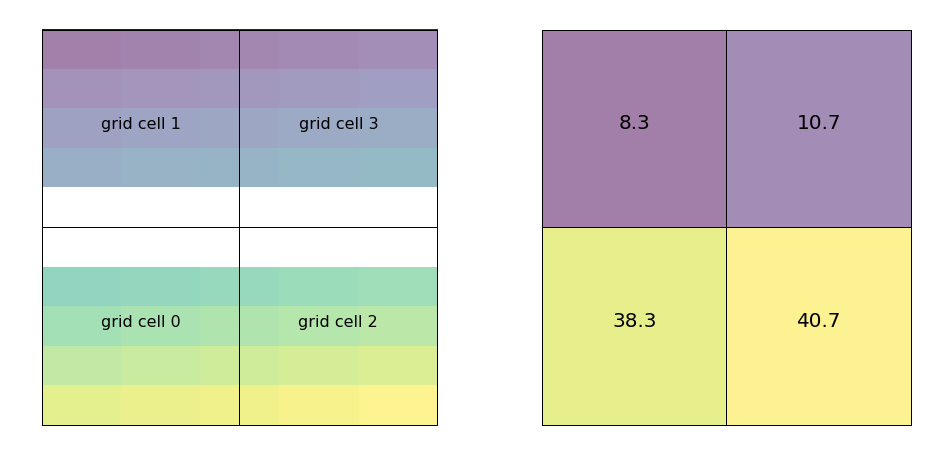

In [26]:
figure, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 8))
grid.plot(color='white', ax=ax1)
grid.apply(lambda x: ax1.annotate(
    s=x['name'], 
    xy=x.geometry.representative_point().coords[0], 
    ha='center',
    size=16
), axis=1)

with rasterio.open(range_fp) as raster:
    img = rp.show(raster, ax=ax1)

ax1.axis('off')

ax = merged.plot(column='value', figsize=(6, 6), ax=ax2)
merged.apply(lambda x: ax2.annotate(
    s="{:2.1f}".format(x['value']),
    xy=x.geometry.representative_point().coords[0], 
    ha='center',
    size=20
), axis=1)    
    
ax2.axis('off')
plt.savefig("images/rasterstats.png", bbox_inches='tight', transparent=True)
pass